In [36]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

from scipy.optimize import minimize

In [37]:
mpl.rc('font', size=12)
#mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [38]:
PV_tab = Table.read('cache/SGA_PV.fits', format = 'fits')

In [6]:
PV_tab

SGA_ID,PGC,RMAG,RMAG_ERR,VMAX,VMAX_ERR,LOG_VMAX,LOG_VMAX_ERR,ABS_MAG_CALC,ABS_MAG_CALC_ERR,Z_OBS,Z_OBS_ERR,Z_H,Z_H_ERR,Z_P,Z_P_ERR,ABS_MAG_TF,ABS_MAG_TF_ERR
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1548,3502220,17.070053100585938,0.010217264294624329,153.61304846436158,3.6373473993169387,2.186428107852915,0.010276527854141184,-19.281223798701404,23768.12523417303,0.0621060809646368,7.92270841139101e-06,0.06775419493083637,0.09465204027288213,-0.005289713674752172,0.08817699697311762,-19.470234119372968,1.9031031488551746
1583,4006227,17.30707550048828,0.015975113958120346,66.73848646769699,10.953677162903615,1.824376353260026,0.0712317006320059,-17.827886150010855,18785.22950782002,0.0354708074996139,6.26174316927334e-06,0.024221831540616027,0.08343649257886888,0.010982948822793048,0.08235800970220192,-16.999565669851414,1.6605167714096856
5732,1139914,16.209707260131836,0.02691706269979477,80.98794915814094,1.7234618911255648,1.9084204015517616,0.009235725419938081,-18.23493962318547,12631.520385223259,0.0258111955991612,4.21050679507442e-06,0.019029961722090892,0.03384710414525085,0.00665459714806671,0.03343605637516679,-17.573088587087224,1.6618527892110377
8032,44973,13.112324714660645,0.02716110832989216,285.8022844567438,13.057899790720636,2.4560656958440097,0.019828842585862805,-21.212104536814557,35516.7472537965,0.0244210647760972,1.18389157512655e-05,0.025550297127156698,0.022857178601858624,-0.0011010989458271059,0.022263182722414725,-21.310261333724647,2.1400622019214515
9519,1120485,16.026517868041992,0.01050059124827385,86.02068818165945,9.91627156141224,1.9346029126693836,0.05003054437979374,-17.668586393631415,14871.691477333441,0.018276776355794,4.95723049244448e-06,0.01899040916032868,0.03662590607703806,-0.0007003331906948462,0.035918155603880855,-17.751760015486447,1.717637445350886
9769,3417258,17.31427764892578,0.0224118921905756,176.49923646725716,7.1375235027085004,2.2467428309772455,0.017550700287307753,-20.08680020380467,16659.12621962967,0.100715036816642,5.55304207320989e-06,0.09164305152188844,0.07423901187022365,0.00831039530925981,0.06857183537040434,-19.88182633395145,1.957808017352348
10325,3384559,17.301721572875977,0.028219928964972496,112.36522695185306,15.639226791469456,2.0506319333023058,0.060405025750591514,-19.432962029975947,14992.076571185939,0.0740995321352292,4.99735885706198e-06,0.04919638806346224,0.0664248441006515,0.023735445866079896,0.06481290666764813,-18.543550793655697,1.8310072408455926
11977,3088810,16.535913467407227,0.01605234667658806,218.17650945393586,2.5746559381372505,2.338807989315039,0.005121544386003142,-20.73881060499413,16575.863281109552,0.0950218671155842,5.52528776036985e-06,0.08552215206448233,0.051615873954495003,0.008751286220216592,0.047965469368928815,-20.510085910434277,2.034326100278104
11998,3412093,17.044811248779297,0.03201938048005104,140.15673053636965,1.4772799821313698,2.1466139580693353,0.004574446833851076,-19.275952181122868,10035.63506324922,0.0612394711056806,3.34521168774974e-06,0.05909474560159539,0.03950313374323545,0.0020250553720451148,0.037374493719449196,-19.198539361739698,1.867529769324636


### Using PV measurements to find $H_0$
$$v_{pec}=cz_{pec}$$
From Hubble's law,
$$v=H_0d$$
where $d=10^{\frac{1}{5}(m-M)+1}$

In [58]:
d_TF = 10**((PV_tab['RMAG']-PV_tab['ABS_MAG_CALC'])/5+1) *1e-6
d_TF_err = 2*np.log(10)*10**((PV_tab['RMAG']-PV_tab['ABS_MAG_CALC'])/5)*np.sqrt(PV_tab['RMAG_ERR']**2+PV_tab['ABS_MAG_CALC_ERR']**2) *1e-6
z = PV_tab['Z_H']
dz = PV_tab['Z_H_ERR']

In [56]:
z[0], dz[0]

(0.06775419493083637, 0.09465204027288213)

In [57]:
d_TF[0], d_TF_err[0]

(186.31824289391048, 2.039369835465913)

In [40]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def l2norm(pars, x, y, dy):
    '''
    Linear fit that uses the l2-norm
    '''
    a, b = pars
    return np.sum((y - a - b*x)**2/dy**2)

def fit_H0(d, v):
    fmin = 1e99
    a = 0
    b = 75
    # a, b = 28, -5
    hess_inv = np.ones((2,2))
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(1000):
        _a, _b = np.random.uniform(-1,1), np.random.uniform(50,100)
        
        res = minimize(l1norm_noerror, 
                       [_a, _b], 
                       # args=(logv, r),# dlogv),
                       args=(d, v),
                       method='L-BFGS-B', 
                       bounds=[[0,0], [50,120]])
        
        if res.fun < fmin and res.success:
            # print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
    
    if succ_res is None:
        print('No successful fits')
    # else:
    #     print(succ_res)
    
    return a, b, hess_inv

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


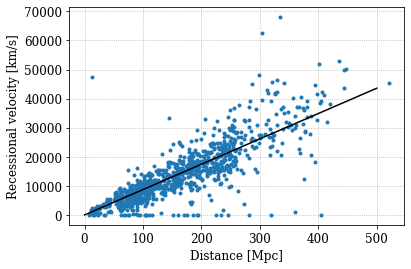

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (6,4))
ax.plot(d_TF, 3e5 * z, '.')
ax.set(xlabel = 'Distance [Mpc]',
       ylabel = 'Recessional velocity [km/s]')
       
p, q, _ = fit_H0(d_TF, 3e5 * z)
d = np.linspace(0, 5e2, 10)
ax.plot(d, p+q*d, color = 'k')
ax.grid(ls = ':')

In [42]:
p,q

(0.0, 87.15004273502117)

In [50]:
H0 = []
for i in range(1000):
    _D = np.random.normal(d_TF, d_TF_err/100)
    # _z = np.random.normal(z, dz)
    a, b, _ = fit_H0(_D, 3e5 *z)
    if b == 75:
        continue
    H0.append(b)

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


No successful fits


KeyboardInterrupt: 

In [44]:
H0

[]

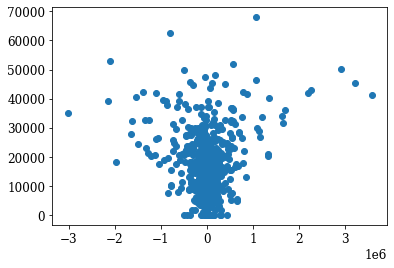

In [51]:
plt.plot(_D, 3e5 *z, 'o')